In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
spotify_df_test = pd.read_csv('/Users/anikasethi/Desktop/test_dataset.csv')
spotify_df_test = spotify_df_test.drop_duplicates(subset='track_id', keep='first')

# Features to train on (need to be normalized)
train_features = ['popularity', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence', 'tempo', 'time_signature']

# Split the data into training (70%) and testing (30%)
train_data, test_data = train_test_split(spotify_df_test, test_size=0.3, random_state=42)

# Normalize the training data
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_data[train_features])

# Apply normalization to the testing data using the same scaler
test_features_scaled = scaler.transform(test_data[train_features])

# Add normalized features back to the DataFrames
train_data[train_features] = train_features_scaled
test_data[train_features] = test_features_scaled

# Train K-Means with 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train_data[train_features])

# Add cluster labels to the training and testing data
train_data['cluster'] = kmeans.labels_
test_data['cluster'] = kmeans.predict(test_data[train_features])

# Randomly select 10 songs from the testing data
selected_songs = test_data.sample(n=10, random_state=42)

# Generate 10 recommendations
recommendations = []
used_ids = set()  # Track IDs of already recommended songs

for _, song in selected_songs.iterrows():
    cluster_label = song['cluster']  # Get the cluster of the selected song
    
    # Filter songs in the same cluster from the training dataset
    cluster_songs = train_data[train_data['cluster'] == cluster_label]
    
    # Exclude already recommended songs
    cluster_songs = cluster_songs[~cluster_songs['track_id'].isin(used_ids)]
    
    # If the cluster is empty, skip or fallback to another cluster
    if cluster_songs.empty:
        print(f"No songs available in cluster {cluster_label} for recommendation.")
        continue
    
    # Ensure numeric arrays for features
    selected_song_features = song[train_features].values.astype(float)
    cluster_songs_features = cluster_songs[train_features].values.astype(float)
    
    # Compute Euclidean distances
    distances = np.linalg.norm(cluster_songs_features - selected_song_features, axis=1)
    
    # Find the index of the closest song
    nearest_song_idx = np.argmin(distances)
    
    # Get the nearest song from the DataFrame
    nearest_song = cluster_songs.iloc[nearest_song_idx]
    recommendations.append(nearest_song)
    
    # Add the recommended song's ID to the used list
    used_ids.add(nearest_song['track_id'])

# Combine all recommendations into a single DataFrame
recommended_songs = pd.DataFrame(recommendations)

# Display the selected and recommended songs
print("\nSelected Songs:")
print(selected_songs[['track_id', 'track_name', 'cluster']])

# Check if recommendations are empty
if recommended_songs.empty:
    print("No recommendations could be made.")
else:
    print("\nRecommended Songs:")
    print(recommended_songs[['track_id', 'track_name', 'cluster']])




Selected Songs:
                     track_id  \
673    3tInTDUq8wdIMw5ftohmqJ   
5444   5HhYHpxwdGTCO5YK7dycoT   
80400  2MvCNH9ua0CeOgUQfZf56z   
76563  6jtro2UfTOFqgQ6A3OptWJ   
62056  0Rs16msoj79XTObU9iEIqd   
46861  6b2fIv4A1u9qFDA0qE3CH2   
97889  7IrmGMCzgByMVNMpUEOIXI   
23097  4VmgXxoTyo1RjJXFK8Ed6g   
13983  6KBSVTTmLuR5PT9gpLW1OB   
21894  2maIfRJZY51Ls412KzKs6Z   

                                            track_name  cluster  
673                                   Girls Chase Boys        4  
5444                                        My Dearest        7  
80400                                         Guzarish        5  
76563                                             Soli        5  
62056                                         December        3  
46861                           Only If I Had One More        4  
97889  Então Me Pega (feat. Diego & Arnaldo) - Ao Vivo        4  
23097                         Stay The Night - Re-Edit        5  
13983                    

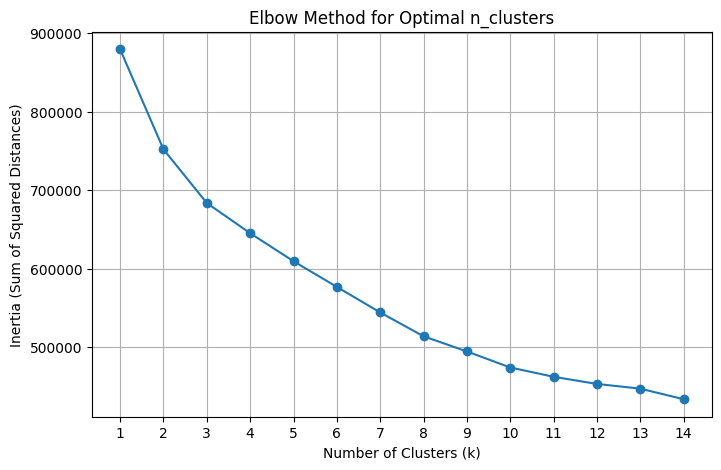

In [ ]:
# elbow method 
inertia = []

# try the following cluster values
cluster_range = range(1, 15)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_data[train_features])
    inertia.append(kmeans.inertia_)

# plot inertia values to pick
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal n_clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_range)
plt.grid()
plt.show()

# picking k = 10

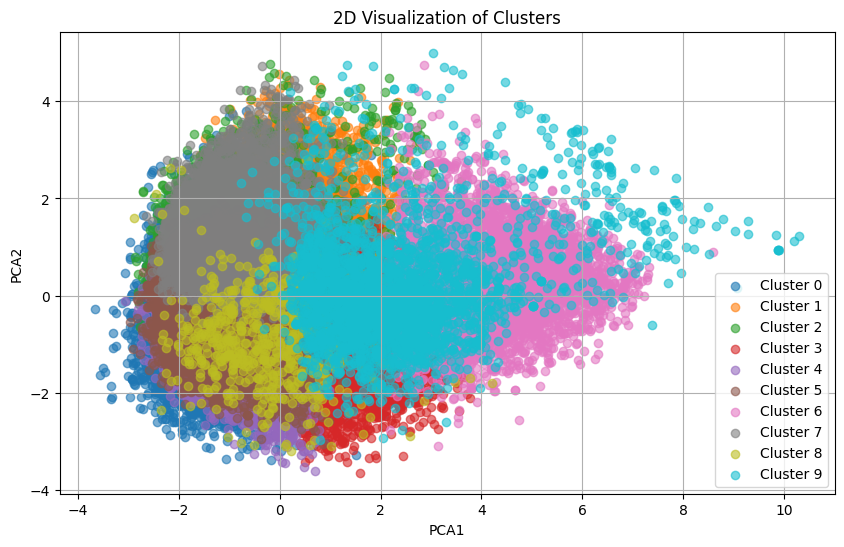

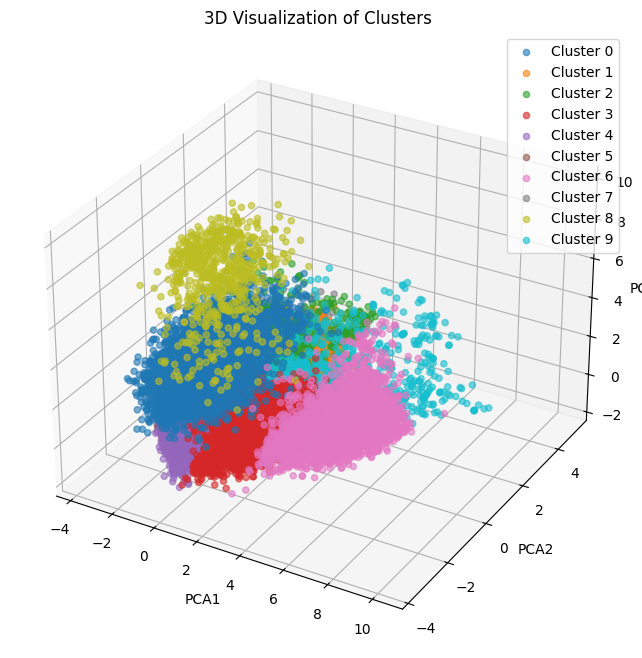

In [4]:
# Perform PCA for dimensionality reduction
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

# Apply PCA to the scaled training features
train_pca_2d = pca_2d.fit_transform(train_data[train_features])
train_pca_3d = pca_3d.fit_transform(train_data[train_features])

# Add PCA results to the training DataFrame for visualization
train_data['PCA1_2D'] = train_pca_2d[:, 0]
train_data['PCA2_2D'] = train_pca_2d[:, 1]
train_data['PCA1_3D'] = train_pca_3d[:, 0]
train_data['PCA2_3D'] = train_pca_3d[:, 1]
train_data['PCA3_3D'] = train_pca_3d[:, 2]

# 2D Scatter Plot
plt.figure(figsize=(10, 6))
for cluster in range(10):  # Assuming 10 clusters
    cluster_data = train_data[train_data['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1_2D'], cluster_data['PCA2_2D'], label=f'Cluster {cluster}', alpha=0.6)

plt.title("2D Visualization of Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(10):  # Assuming 10 clusters
    cluster_data = train_data[train_data['cluster'] == cluster]
    ax.scatter(cluster_data['PCA1_3D'], cluster_data['PCA2_3D'], cluster_data['PCA3_3D'],
               label=f'Cluster {cluster}', alpha=0.6)

ax.set_title("3D Visualization of Clusters")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.legend()
plt.show()
